# Step 13: Plate characters recognition (KZ)

## Imports

In [1]:
import os
from argparse import Namespace
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.local_utils.constants import (
    KZ_PLATES_IMAGES_PATH,
    KZ_CHARACTERS_IMAGES_PATH,
    KZ_CHARACTERS_BEST_MODEL_FILE,
    CHARACTERS_SIZE,
)
from src.networks.character_classifier import CharacterClassifier

In [2]:
args = Namespace()
args.images = os.path.join(KZ_PLATES_IMAGES_PATH, '*.jpg')

In [3]:
def sort_contours(cnts, reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))

    return cnts

In [4]:
classnames = os.listdir(KZ_CHARACTERS_IMAGES_PATH)

def image2data(img):
    res = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return np.array([res.astype('float32') / 255])

model = CharacterClassifier(len(classnames))
model.load_weights(KZ_CHARACTERS_BEST_MODEL_FILE)

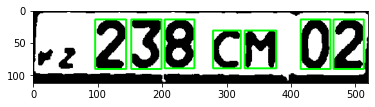

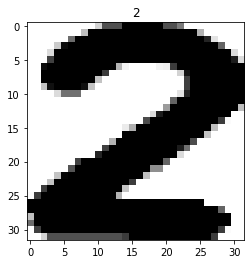

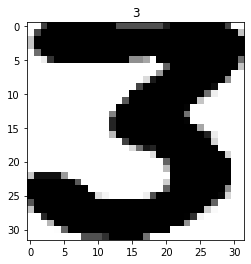

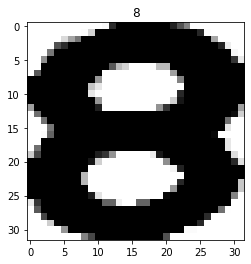

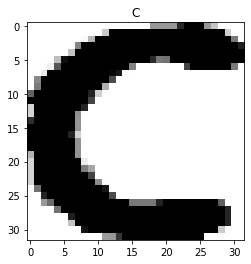

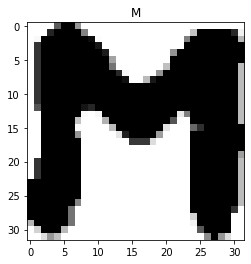

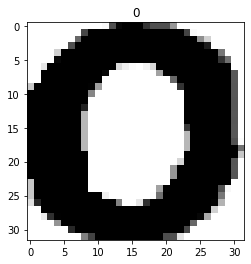

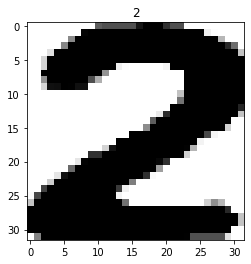

In [57]:
for idx, input_image in enumerate(list(glob(args.images))[1:2]):
    image = cv2.imread(input_image)
    # display_image = image.copy()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.bitwise_not(image)
    _, image = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)

    display_image = cv2.bitwise_not(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))

    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    crop_characters = []

    for contour in sort_contours(contours):
        x, y, w, h = cv2.boundingRect(contour)
        ratio = h / w

        if 0.9 <= ratio <= 2.5:
            if 0.35 <= h / image.shape[0] <= 0.8:
                cv2.rectangle(
                    display_image,
                    (x, y),
                    (x + w, y + h),
                    (0, 255, 0),
                    2,
                )

                curr_num = cv2.bitwise_not(image[y:y+h,x:x+w].copy())
                crop_characters.append(cv2.resize(curr_num, dsize=CHARACTERS_SIZE))

    plt.imshow(display_image)
    plt.show()

    classes = []

    for img in crop_characters:
        score = model.predict(image2data(img))
        classes.append(classnames[np.argmax(score[0])])

    for i in range(len(crop_characters)):
        plt.imshow(crop_characters[i], cmap="gray")
        plt.title(classes[i])
        plt.show()
